In [7]:
# produce supplementary figure on interrater reliability
# panel x: fraction overlap of lesions with different border zones

#4 panels
# panel 1 - zoomed in view of 3 lesion masks
# ?plus predicted lesions??
# 4 raincloud plots of lesion areas
# 4 DICE overlaps
# 4 distances. geodesic distance from border of 1 lesion to border of the other
# background = 1, 1 lesion = 1, 2 masks = 2. Distance from 2-0 through 1.
# store max per subject

import glob
import nibabel as nb
import numpy as np
import pandas as pd
import seaborn as sns

from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH
import os
import matplotlib_surface_plotting as msp
import h5py
import ptitprince as pt
import potpourri3d as pp3d

import matplotlib.pyplot as plt
%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

In [2]:
#get ids of masks and load them
mask_filenames=glob.glob('/rds/project/kw350/rds-kw350-meld/meld_data/inter_rater_masks/*')
subject_ids = []
raters=['RG','KM', 'FD']
masks = {}
for rater in raters:
    masks[rater]={}

#get subjids and load data
hemis={}
for mf in mask_filenames:
    subj = mf.split('.')[1]
    hemi = mf.split('.')[0].split('/')[-1]
    if subj not in subject_ids:
        subject_ids.append(subj)
        hemis[subj]=hemi
    for rater in raters:
        if rater in mf:
            masks[rater][subj] = np.asanyarray(nb.load(mf).dataobj).ravel()

In [3]:
# load cohort
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset="MELD_dataset_V6.csv",
             data_dir=MELD_DATA_PATH)

In [8]:
# iterate over all pairs of maskers
# calculate how much of one lesion mask is contained in another one at a given distance
solver = pp3d.MeshHeatMethodDistanceSolver(cohort.surf["coords"],
                                           cohort.surf["faces"])

boundary_zone = [0,5,10,15,20,25,30,35,40,45,50,55,60]
fraction_in_mask = {f'{rater1}_{rater2}':{} for rater1 in raters for rater2 in raters if rater2!=rater1}
for rater1 in raters:
    for subj in subject_ids:
        print(rater1, subj)
        mask1 = masks[rater1][subj] > 0
        # calculate boundary vertices of mask
        non_mask_and_neighbours=flatten(np.array(cohort.neighbours)[~mask1])
        mask_boundary_vertices=np.setdiff1d(non_mask_and_neighbours,np.where(~mask1)[0])
        distances=solver.compute_distance_multisource(mask_boundary_vertices)
        #flip sign for distances inside the lesion
        distances[mask1]=-distances[mask1]
        # calculate fraction of other masks in this mask + boundary zone
        for rater2 in raters:
            if rater1 == rater2:
                continue
            mask2 = masks[rater2][subj] > 0
            res = []
            num_mask2 = len(np.where(mask2)[0])
            for b in boundary_zone:
                res.append(len(np.where(mask2[distances <= b])[0]) / num_mask2)
            fraction_in_mask[f'{rater1}_{rater2}'][subj] = res

RG MELD_H4_15T_FCD_0022
RG MELD_H4_3T_FCD_0031
RG MELD_H4_15T_FCD_0004
RG MELD_H4_3T_FCD_0016
RG MELD_H4_15T_FCD_0006
RG MELD_H4_3T_FCD_0032
RG MELD_H4_3T_FCD_0033
RG MELD_H4_3T_FCD_0010
RG MELD_H4_15T_FCD_0005
RG MELD_H4_3T_FCD_0006
KM MELD_H4_15T_FCD_0022
KM MELD_H4_3T_FCD_0031
KM MELD_H4_15T_FCD_0004
KM MELD_H4_3T_FCD_0016
KM MELD_H4_15T_FCD_0006
KM MELD_H4_3T_FCD_0032
KM MELD_H4_3T_FCD_0033
KM MELD_H4_3T_FCD_0010
KM MELD_H4_15T_FCD_0005
KM MELD_H4_3T_FCD_0006
FD MELD_H4_15T_FCD_0022
FD MELD_H4_3T_FCD_0031
FD MELD_H4_15T_FCD_0004
FD MELD_H4_3T_FCD_0016
FD MELD_H4_15T_FCD_0006
FD MELD_H4_3T_FCD_0032
FD MELD_H4_3T_FCD_0033
FD MELD_H4_3T_FCD_0010
FD MELD_H4_15T_FCD_0005
FD MELD_H4_3T_FCD_0006


In [9]:
# convert results in dataframe for plotting
dfs = []
for key, vals in fraction_in_mask.items():
    df = pd.DataFrame(vals)
    df['distances'] =  boundary_zone
    # bring df in long format
    df = pd.melt(df, value_vars=subject_ids, id_vars='distances', var_name='subject_id', value_name='fraction')
    df['rater1'] = key.split('_')[0]
    df['rater2'] = key.split('_')[1]
    df['raters'] = key
    dfs.append(df)
df = pd.concat(dfs)
df['masks_overlap'] = df['fraction'] > 0

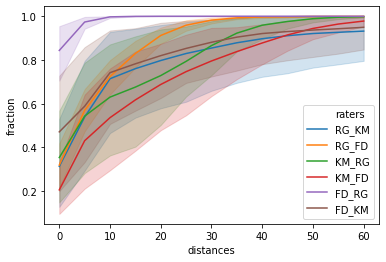

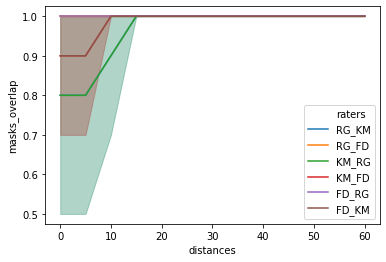

In [10]:
sns.lineplot(data = df, x='distances', y='fraction', hue='raters')
plt.figure()
g = sns.lineplot(data=df, x='distances', y='masks_overlap', hue='raters')
g.legend(loc='lower right')

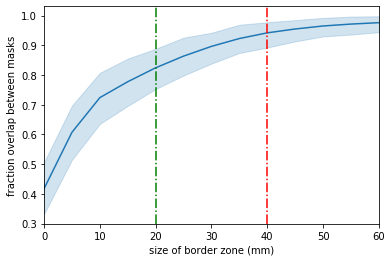

In [52]:
# make plots for suppl figure 
mean_20 = df.groupby('distances').mean().loc[20]['fraction']
mean_40 = df.groupby('distances').mean().loc[40]['fraction']

# fraction overlap
g = sns.lineplot(data = df, x='distances', y='fraction')
#g.plot([20,20],[0,mean_20], '--', c='black')
#g.plot([0,20],[mean_20, mean_20],'--', c='black')
#g.plot([40,40],[0,mean_40], '--', c='black')
#g.plot([0,40],[mean_40,mean_40], '--', c='black')
g.axvline(20, ls='-.', c='green')
g.axvline(40, ls='-.', c='red')
g.set_ylabel('fraction overlap between masks')
g.set_xlabel('size of border zone (mm)')
g.set_xlim([0,60])
plt.savefig('interrater_fraction_overlap.png', dpi=300)

In [108]:
print(df.groupby('distances').mean().loc[0]['fraction'])
print(mean_20)
print(mean_40)

0.41779227374359723
0.8243254865001866
0.9419029382942037


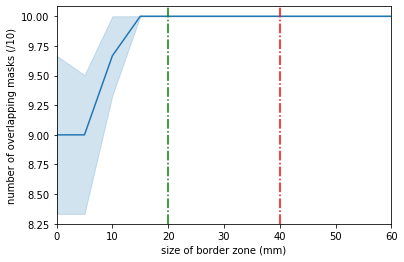

In [51]:
# number of clusters overlapping
df_grp = df.groupby(['distances', 'raters']).sum().reset_index()

g = sns.lineplot(data=df_grp, x='distances', y='masks_overlap')
g.set_ylabel("number of overlapping masks (/10)")
g.set_xlabel("size of border zone (mm)")
g.set_xlim([0,60])
g.axvline(20, ls='-.', c='green')
g.axvline(40, ls='-.', c='red')
plt.savefig('interrater_number_overlap.png', dpi=300)

MELD_H4_15T_FCD_0022
(array([0, 1, 2, 3, 4, 5]), array([161880,      7,     46,    787,    449,    673]))
MELD_H4_3T_FCD_0031
(array([0, 1, 3, 4]), array([119122,  32358,   7654,   4708]))
MELD_H4_15T_FCD_0004
(array([0, 1, 2, 3, 4, 5]), array([153389,   2694,   1713,   1450,   3224,   1372]))
MELD_H4_3T_FCD_0016
(array([0, 1, 3, 4, 5]), array([154635,   6273,   1220,   1170,    544]))
MELD_H4_15T_FCD_0006
(array([0, 2, 3, 4, 5]), array([159337,    701,   1680,   1228,    896]))
MELD_H4_3T_FCD_0032
(array([0, 1, 2, 3, 4, 5]), array([148951,   3233,    373,   5996,   5287,      2]))
MELD_H4_3T_FCD_0033
(array([0, 1, 2, 3, 4, 5]), array([160430,     26,    123,   2733,    465,     65]))
MELD_H4_3T_FCD_0010
(array([0, 2, 3, 4, 5]), array([153492,      6,   6954,   3247,    143]))
MELD_H4_15T_FCD_0005
(array([0, 1, 2, 3, 4]), array([155215,      4,     32,   5224,   3367]))
MELD_H4_3T_FCD_0006
(array([0, 1, 2, 3, 4, 5]), array([156791,     10,     12,   4842,   1638,    549]))


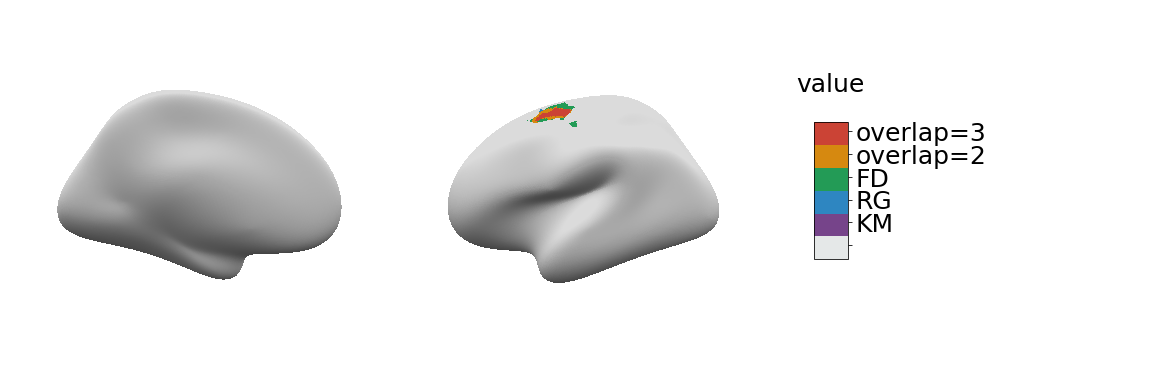

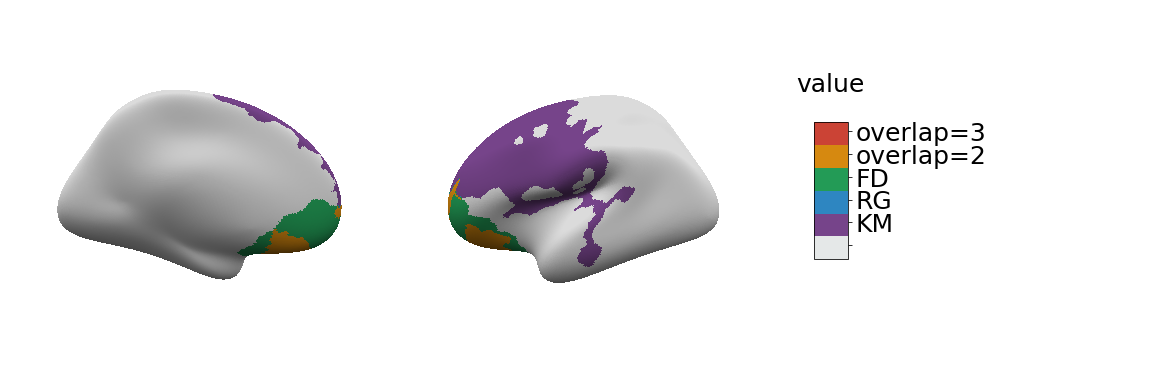

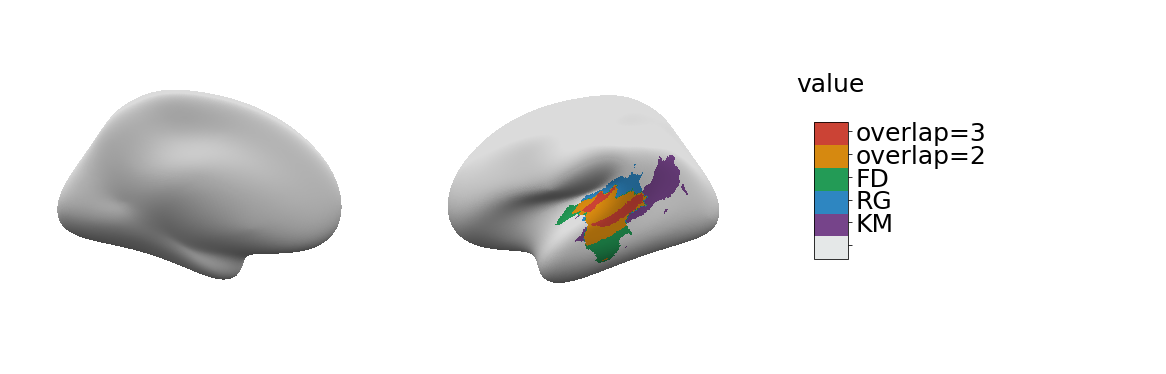

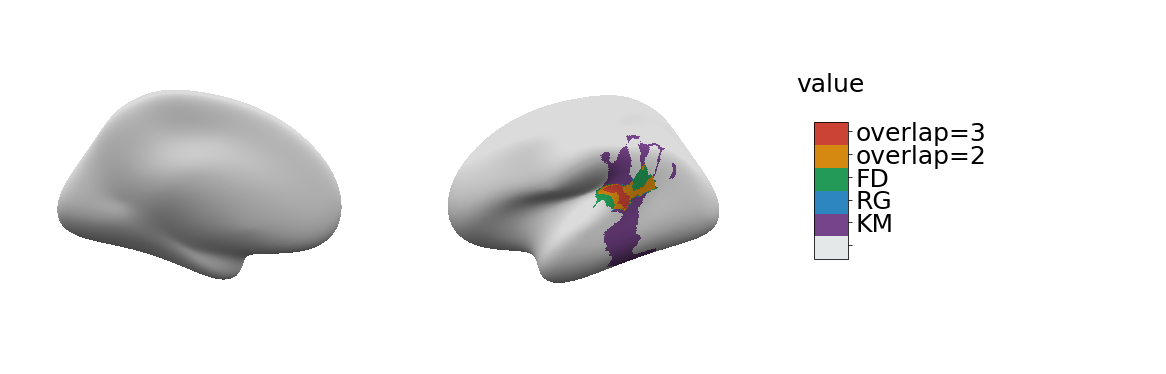

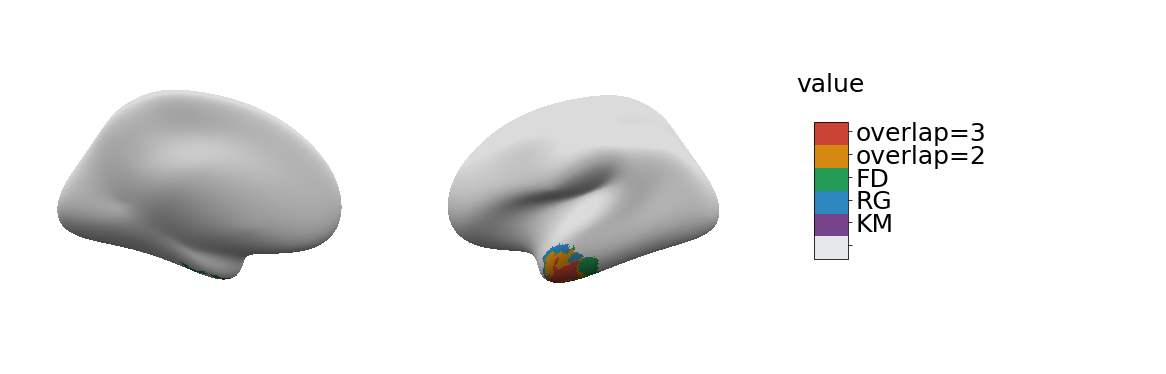

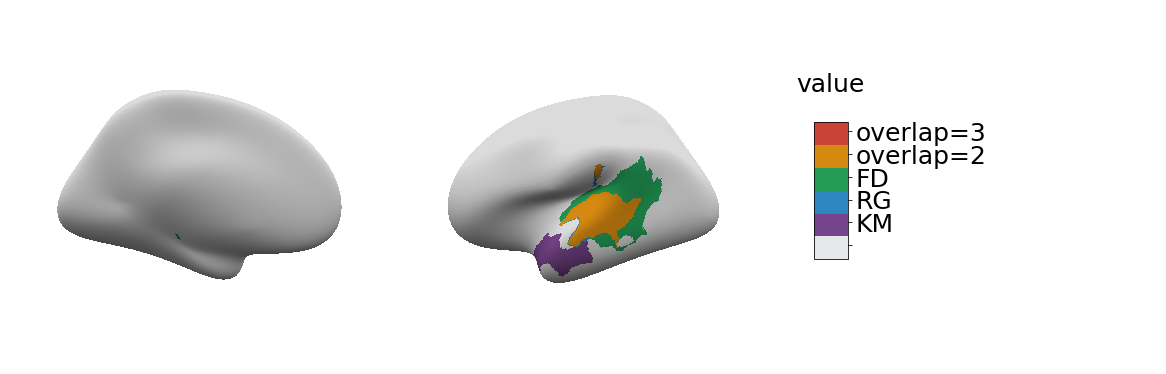

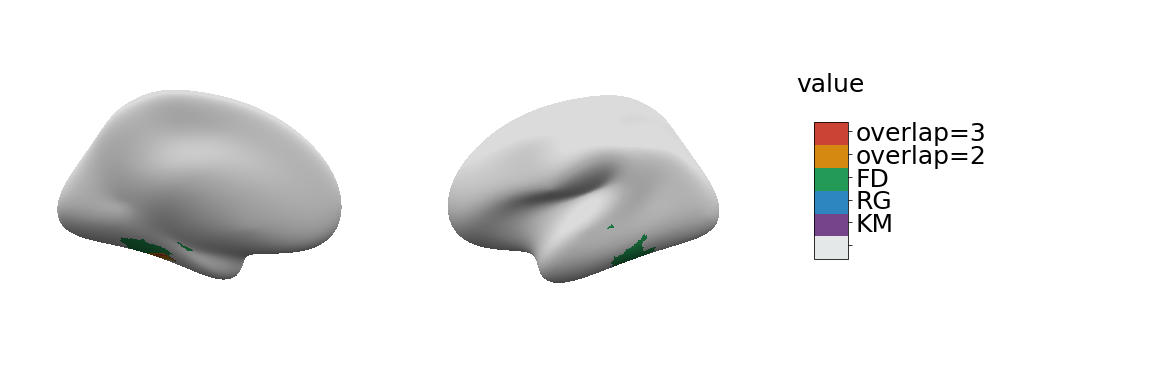

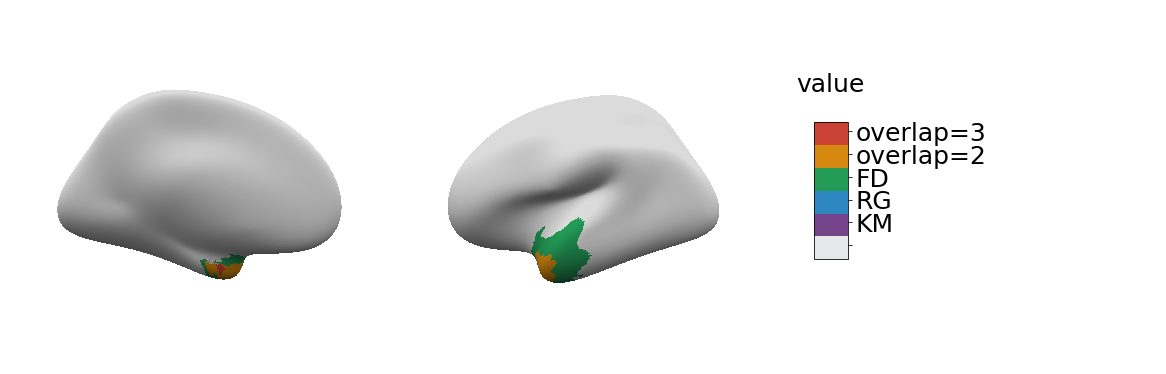

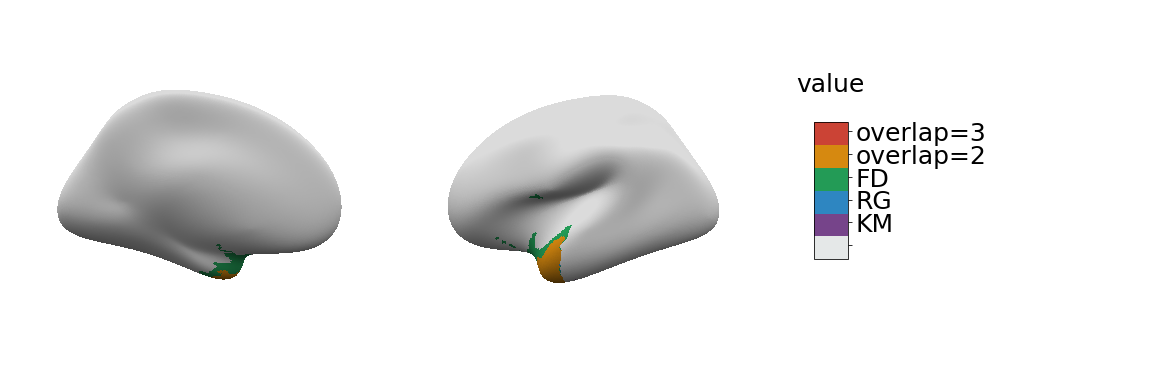

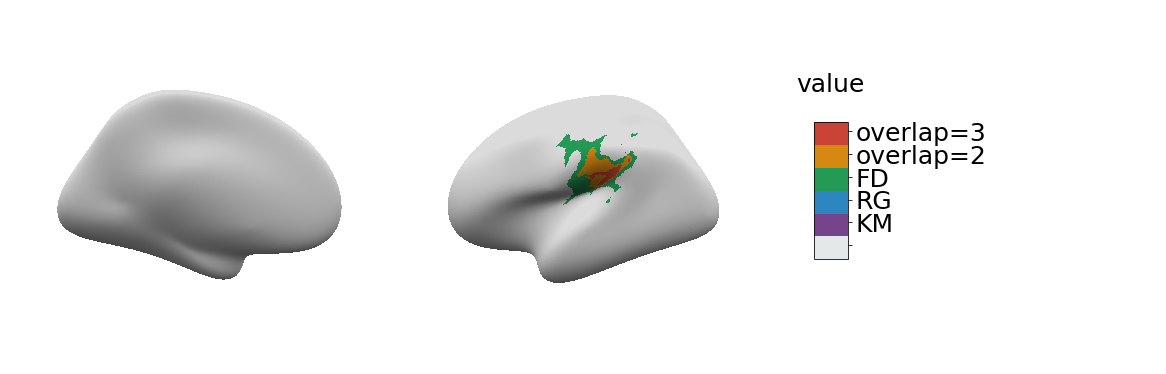

In [107]:
from matplotlib import colors

# make a color map of fixed colors
cmap = colors.ListedColormap([(229/255, 232/255, 232/255), (118/255, 68/255, 138/255),
                              (46/255, 134/255, 193/255), (35/255, 155/255, 86/255), 
                              (214/255, 137/255, 16/255), (203/255, 67/255, 53/255)])

# plot masks of each subject
for subject in subject_ids:
    print(subject)
    mask1 = masks['KM'][subject]>0
    mask2 = masks['RG'][subject]>0
    mask3 = masks['FD'][subject]>0
    overlap3 = mask1 & mask2 & mask3
    overlap2 = (mask1 & mask2) | (mask1 & mask3) | (mask2 & mask3)
    
    combi = mask1.astype(int) + mask2.astype(int)*2 + mask3.astype(int)*3
    combi[overlap2] = 4
    combi[overlap3] = 5
    #combi = (masks['KM'][subject]>0).astype(int) + 2* (masks['RG'][subject]>0).astype(int) + (masks['RG'][subject]>0).astype(int)
    print(np.unique(combi,return_counts=True))
    
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],combi,cmap=cmap,mask=combi==0,
                  #pvals=masks['prediction'][subject],
                 vmin=0,vmax=5,colorbar=True)
    fig = plt.gcf()
    cbar = fig.axes[2].collections[-1].colorbar
    cbar.set_ticks(np.arange(6)/6+0.1)
    cbar.set_ticklabels(['', 'KM', 'RG', 'FD', 'overlap=2', 'overlap=3'])
    fig.show()
    plt.savefig(f'interrater_{subject}.png', dpi=300)
    

# Other

In [11]:
#load predictions
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH
import os
import matplotlib_surface_plotting as msp
import h5py
import ptitprince as pt

def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset="MELD_dataset_V6.csv",
             data_dir=MELD_DATA_PATH)

In [38]:
masks['prediction']={}
for subject in subject_ids:
    print(subject)
    try:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    except KeyError:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    masks['prediction'][subject]=result_hemis[hemis[subject]]
    full=np.zeros_like(cohort.cortex_mask)
    full[cohort.cortex_mask] = result_hemis[hemis[subject]]
    masks['prediction'][subject]=full
    print(sum(np.logical_and(masks['prediction'][subject]>0,masks['KM'][subject]>0)))

MELD_H4_15T_FCD_0022
0
MELD_H4_3T_FCD_0031
897
MELD_H4_15T_FCD_0006
914
MELD_H4_3T_FCD_0032
526
MELD_H4_3T_FCD_0033
273
MELD_H4_3T_FCD_0010
0
MELD_H4_15T_FCD_0005
0
MELD_H4_3T_FCD_0016
1311
MELD_H4_3T_FCD_0006
1260
MELD_H4_15T_FCD_0004
1622


MELD_H4_15T_FCD_0022
(array([0, 1, 2, 3]), array([162667,    199,    294,    682]))
MELD_H4_3T_FCD_0031
(array([0, 1, 2]), array([126776,  33355,   3711]))
MELD_H4_15T_FCD_0006
(array([0, 1, 2, 3]), array([161017,    274,   1655,    896]))
MELD_H4_3T_FCD_0032
(array([0, 1, 2, 3]), array([154947,   3250,   5642,      3]))
MELD_H4_3T_FCD_0033
(array([0, 1, 2, 3]), array([163163,     29,    356,    294]))
MELD_H4_3T_FCD_0010
(array([0, 1, 2, 3]), array([160446,    344,   2909,    143]))
MELD_H4_15T_FCD_0005
(array([0, 1, 2]), array([160439,      4,   3399]))
MELD_H4_3T_FCD_0016
(array([0, 1, 3]), array([155855,   7404,    583]))
MELD_H4_3T_FCD_0006
(array([0, 1, 2, 3]), array([161633,   1597,     63,    549]))
MELD_H4_15T_FCD_0004
(array([0, 1, 2, 3]), array([154839,   3782,   3759,   1462]))


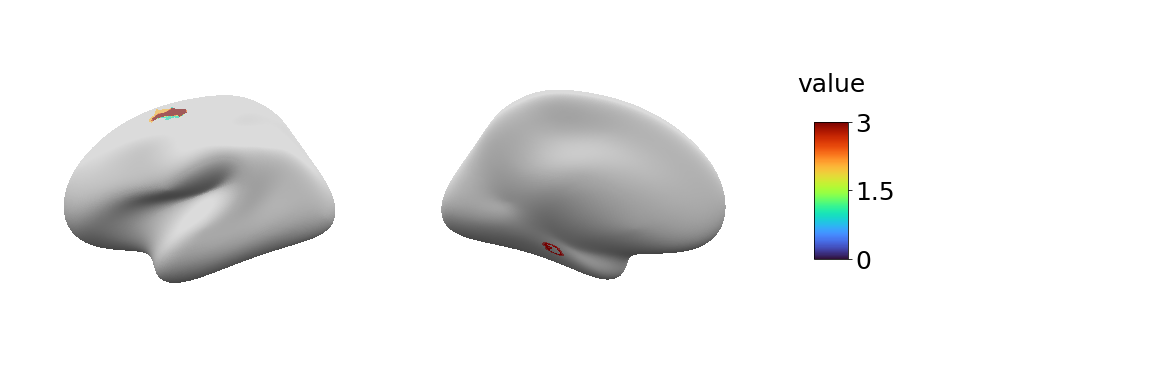

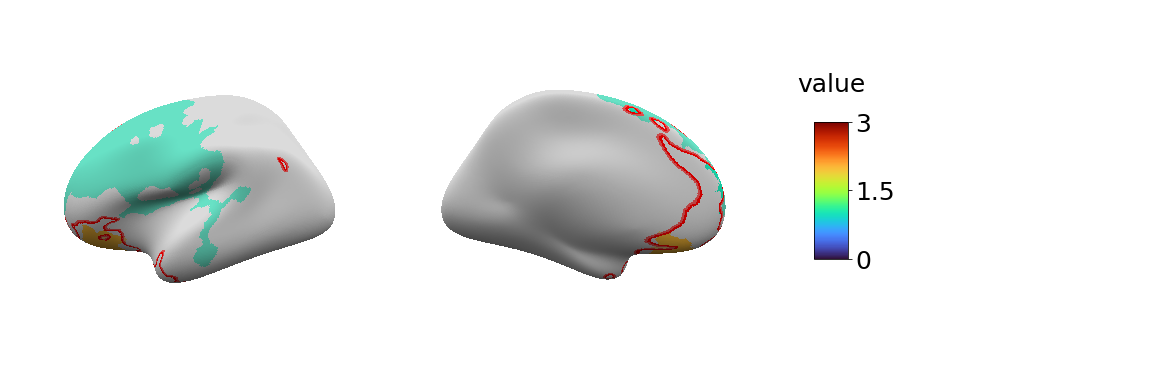

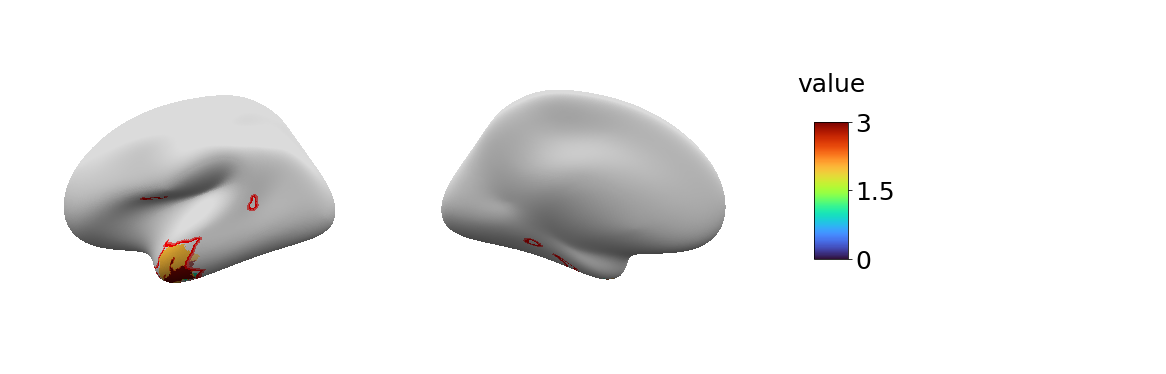

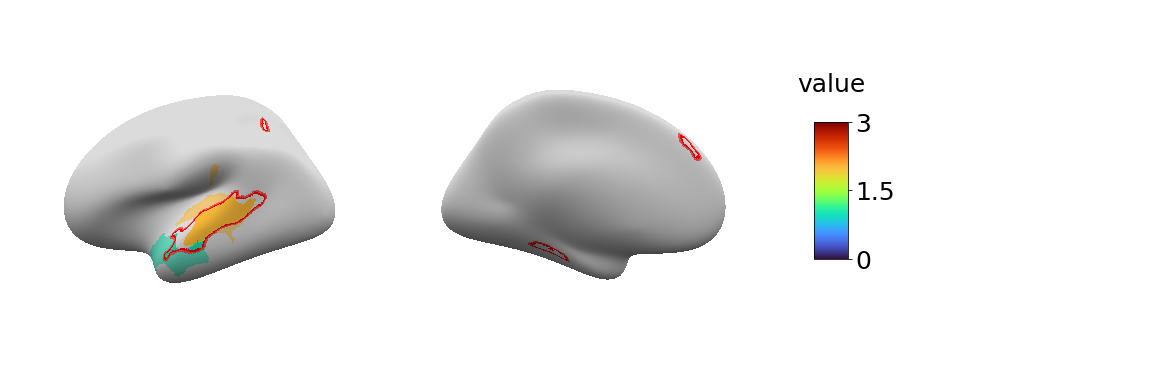

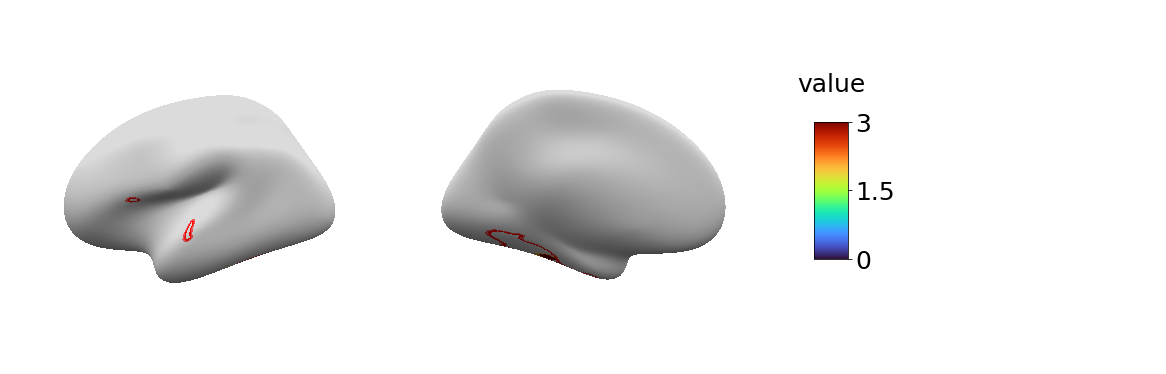

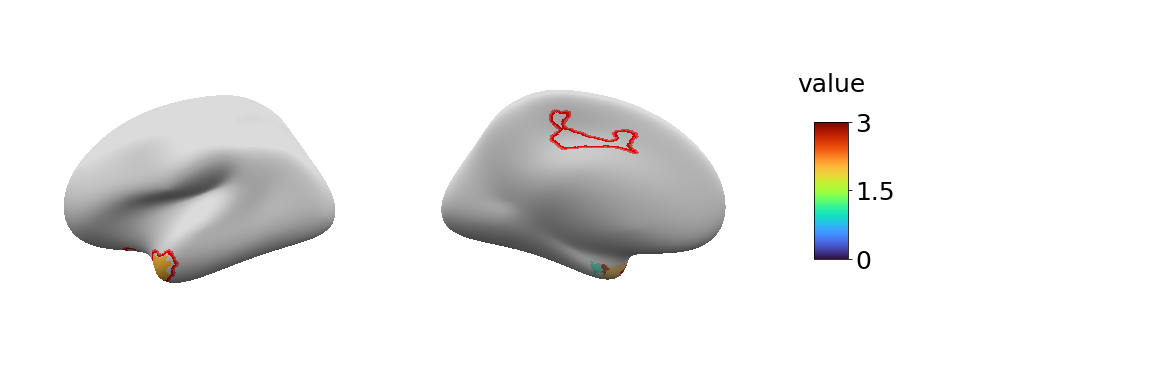

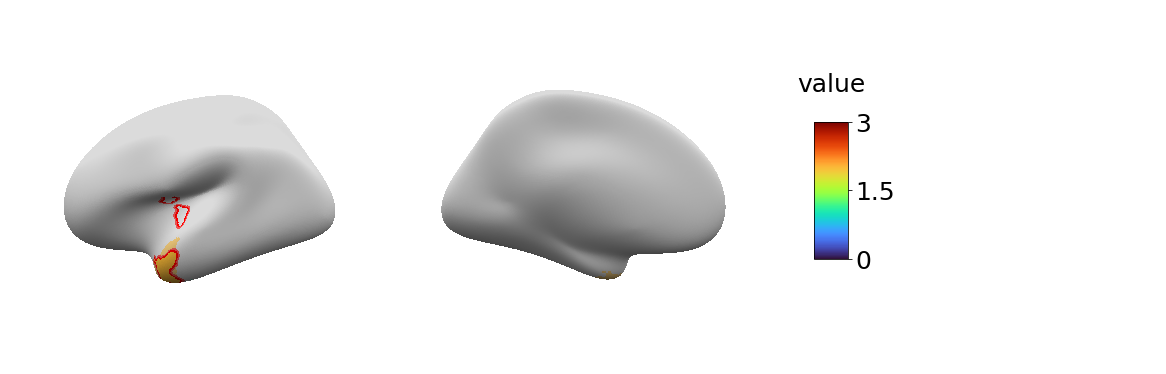

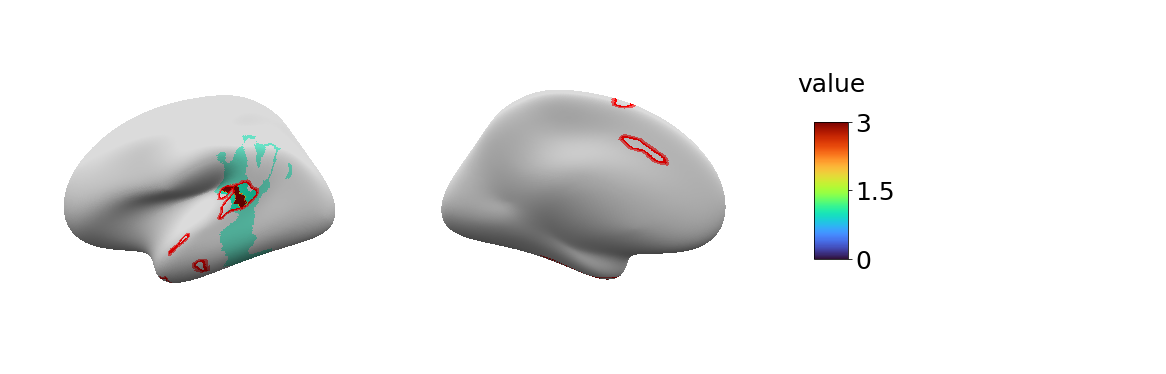

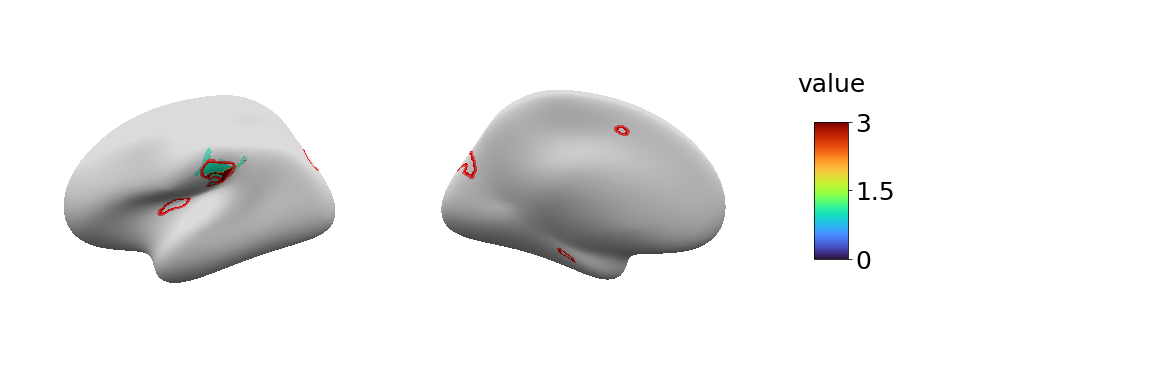

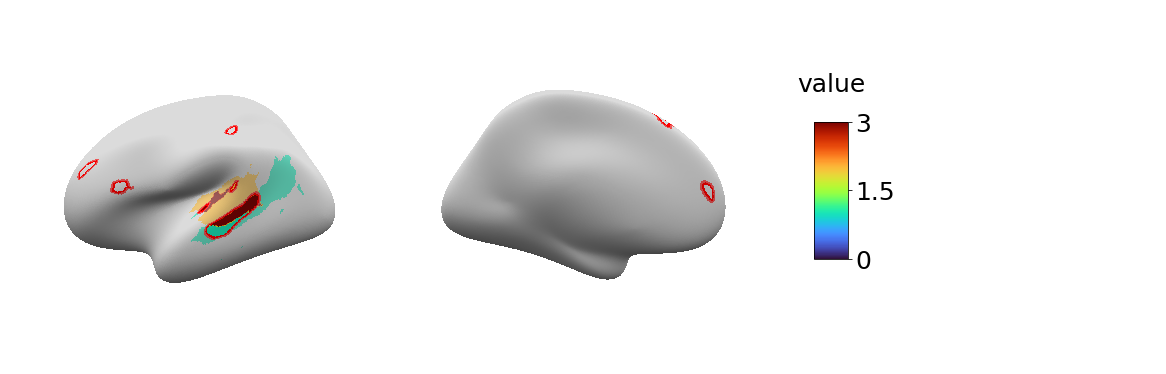

In [48]:
import matplotlib_surface_plotting as msp
overlays=[]
for subject in subject_ids:
    print(subject)
    combi = (masks['KM'][subject]>0).astype(int) + 2* (masks['RG'][subject]>0).astype(int)
    print(np.unique(combi,return_counts=True))
    
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],combi,cmap='turbo',mask=combi==0,
                  pvals=masks['prediction'][subject],
                 vmin=0,vmax=3,colorbar=True)
    break

/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


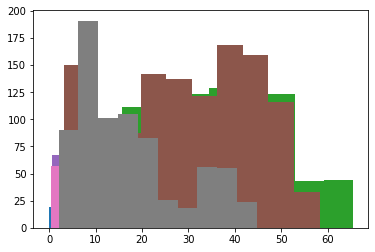

In [79]:
#calculate distances
import potpourri3d as pp3d
def flatten(t):
    return [item for sublist in t for item in sublist]

solver = pp3d.MeshHeatMethodDistanceSolver(cohort.surf["coords"],
                                           cohort.surf["faces"])
med_dists=[]
for subject in subject_ids:
    overlap_vertices = np.where(np.logical_and(masks['KM'][subject]>0,masks['RG'][subject]>0))[0]
    if len(overlap_vertices)>0:
        distances=solver.compute_distance_multisource(overlap_vertices)
        #edge vertices =
        combi_mask  = np.where(np.logical_or(masks['KM'][subject]>0,masks['RG'][subject]>0))[0]

        neighbours = np.unique(flatten(np.array(cohort.neighbours)[combi_mask]))
        edge_vertices=np.setdiff1d(neighbours,combi_mask)
        plt.hist(distances[edge_vertices])
        med_dists.append(np.mean(distances[edge_vertices]))
        

In [80]:
np.mean(med_dists)

15.952388067954253